In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.greedy_search_strategy import GreedySearchStrategy
from lib.model.search.beam_search_strategy import BeamSearchStrategy, EndCriteria
from lib.model.attention_layer import AttentionLayer

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj
from lib.utils.sequencer import Sequencer

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
dataset_name='8k'
# dataset_name='30k'
dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'
image_features_path = f'{dataset_path}/img_features.pkl'
word_embedding_path = './dataset/glove.6B.200d.txt'
line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.3)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.1)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 5663, Val: 2185, Test: 243


In [6]:
save_obj(f'{dataset_path}/train_samples.pkl', train_samples)
save_obj(f'{dataset_path}/val_samples.pkl', val_samples)
save_obj(f'{dataset_path}/test_samples.pkl', test_samples)

In [7]:
train_samples[0]

('./dataset/8k/images/241346794_4319f8af67.jpg',
 ['$ bunch of football player and crowd #',
  '$ football game #',
  '$ large group of football player about to start game with large group watch #',
  '$ two football team at the line of scrimmage #',
  '$ two football team line up before hike #'])

In [8]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [9]:
min_occurs=10
vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [10]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [11]:
len(word_to_index)

1593

In [12]:
dataset.max_desc_len()

174

In [13]:
embedding_vector_dim = 200
embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)

In [14]:
embedding_matrix = embedding_generator.generate(word_to_index)

In [15]:
len(embedding_matrix)

1593

In [16]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [17]:
epochs=12
batch_size = 4
lr=0.001
steps_per_epoch=len(train_samples)/batch_size

In [18]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [19]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=100, 
        evaluate_interval=100, 
        batch_size=batch_size
    )
#,
#    LRScheduler(
#        { 
#            0: 0.001, 
#            6: 0.0001
#            12: 0.00001
#        }, 
#        verbose=1
#    )
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
____________________________________________________________________________________________

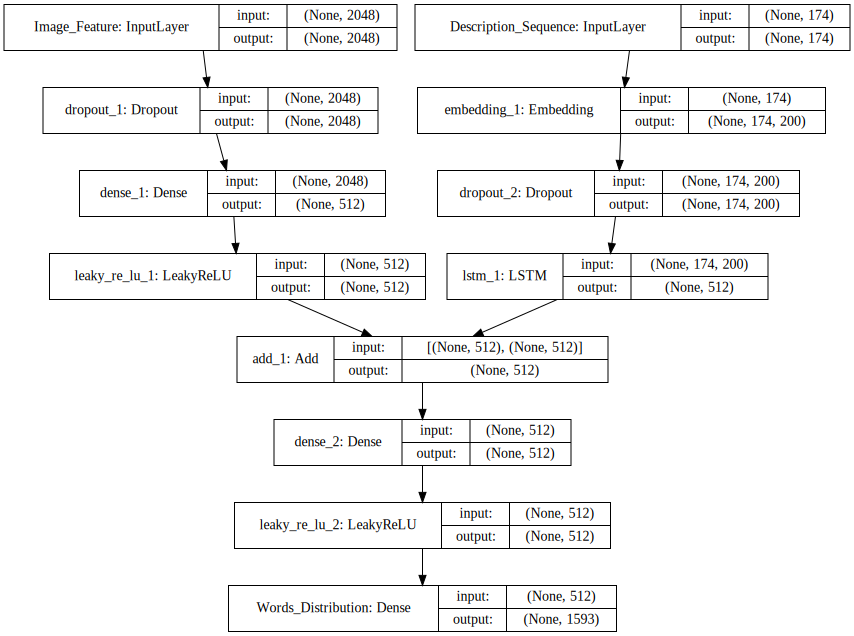

Load weights from weights/8k/weights__epoch_11__loss_3.0595__acc_0.0222.h5


In [20]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
model.show()
model.load(f'{weights_path}/weights__epoch_11__loss_3.0595__acc_0.0222.h5')    

In [21]:
# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

In [22]:
sequencer = Sequencer(
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    max_seq_len=dataset.max_desc_len()
)

search = BeamSearchStrategy(
    model=model,
    sequencer=sequencer,
    seq_prefix='$',
    seq_postfix='#',
    end_criteria=EndCriteria().at_lest_n_end_with(n=10, word='#'),
    k=6
)

def show_random_sample():
    image_path = test_samples[random.randint(0, len(test_samples)-1)][0]
    descriptions = search.perform(image_features[image_path])
    show_sample(image_path, descriptions)

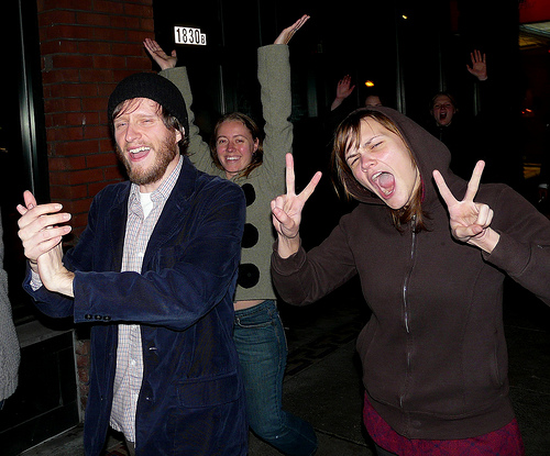

Score: 15.761539021783994, Desc: woman hold hand 
Score: 18.355917049264537, Desc: child hold hand 
Score: 18.518581588954703, Desc: woman be clap 
Score: 19.58261330683042, Desc: man be clap 
Score: 19.611751234871498, Desc: person be clap 
Score: 23.10803077063238, Desc: woman hold drink 


In [23]:
show_random_sample()

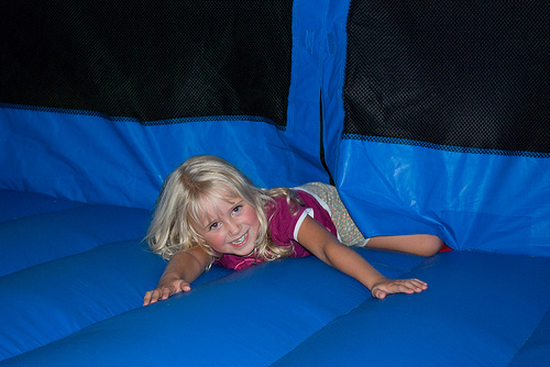

Score: 5.946475094871985, Desc: child on bouncy 
Score: 11.982935805542915, Desc: person on bouncy 
Score: 18.252510238027174, Desc: young girl play 
Score: 19.931781656243224, Desc: girl play  
Score: 20.962200651086462, Desc: child on bed 
Score: 21.04240081905253, Desc: girl be play 


In [24]:
show_random_sample()

In [ ]:
show_random_sample()

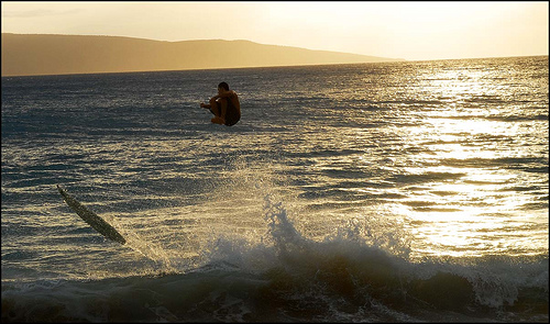

Score: 6.458186513790462, Desc: person on beach 
Score: 8.199414037483226, Desc: surfer ride wave 
Score: 10.163543913184826, Desc: person be surf 
Score: 14.493294604910862, Desc: person on cliff 
Score: 32.328639499832754, Desc: man be surf 
Score: 49.42733718994753, Desc: surfer in wetsuit 


In [26]:
show_random_sample()

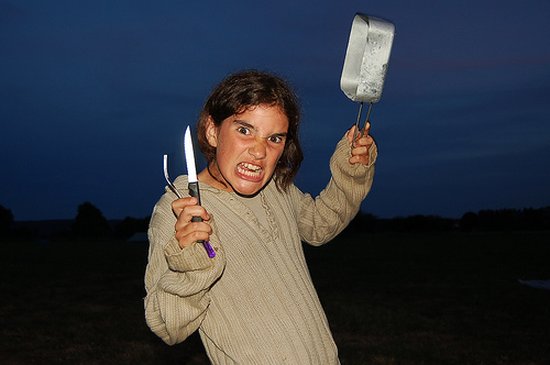

Score: 13.328854794728084, Desc: woman hold baby 
Score: 17.38834027925344, Desc: child hold hand 
Score: 21.531757618876245, Desc: child hold onto 
Score: 21.979651076362977, Desc: child hold up 
Score: 22.566976546662037, Desc: child hold wild 
Score: 24.49951856564799, Desc: girl hold hand 


In [38]:
show_random_sample()

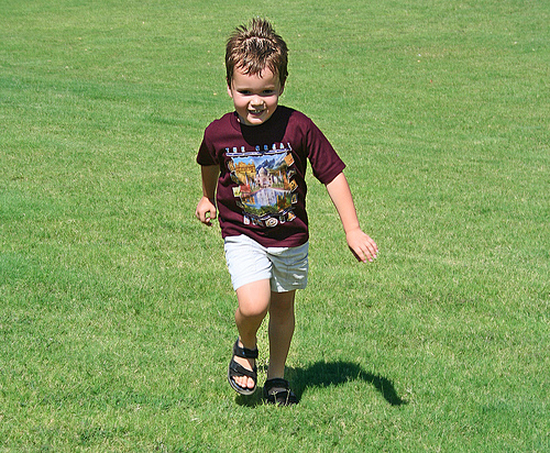

Score: 13.660096546922448, Desc: child play soccer 
Score: 18.096648345482194, Desc: child play outside 
Score: 22.73722379940273, Desc: child play rugby 
Score: 36.510635021948325, Desc: man be rollerblade 
Score: 38.51805748741157, Desc: boy hold stick 
Score: 39.01802402685216, Desc: child with sandal 


In [39]:
show_random_sample()

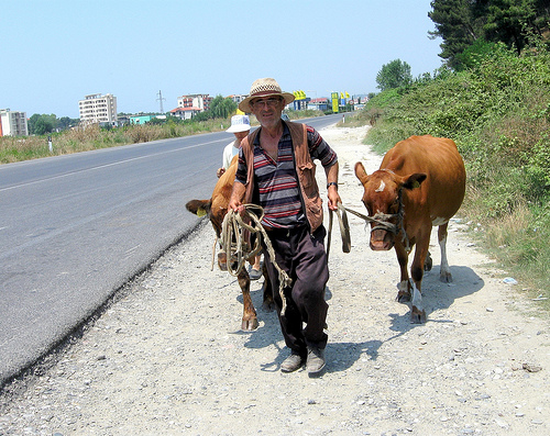

Score: 7.755025116295339, Desc: person lead cow 
Score: 9.099265268917465, Desc: man lead cow 
Score: 10.39037425956565, Desc: dog lead cow 
Score: 10.74338344724939, Desc: woman lead cow 
Score: 14.50930882033104, Desc: woman lead dog 
Score: 17.753355818914578, Desc: cow lead cow 


In [29]:
show_random_sample()

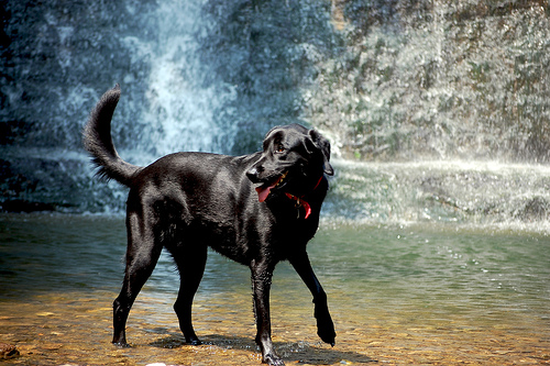

Score: 3.3951182721468234, Desc: black dog play 
Score: 4.218450748238969, Desc: brown dog swim 
Score: 4.893872233886226, Desc: brown dog play 
Score: 8.162940950331311, Desc: dog play outside 
Score: 8.185015821301203, Desc: dog play together 
Score: 11.701605600628644, Desc: dog be play 


In [30]:
show_random_sample()

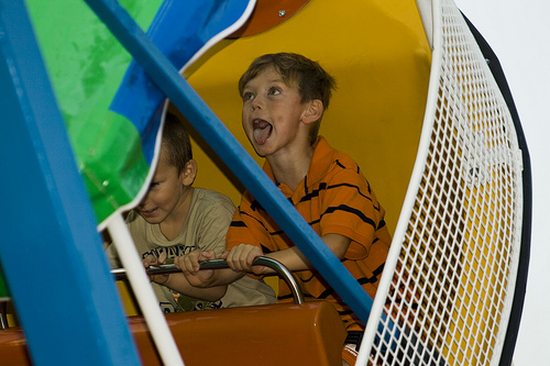

Score: 13.749153895052487, Desc: kid play  
Score: 13.761615369642978, Desc: child play outside 
Score: 14.873131657958712, Desc: kid ride skateboard 
Score: 16.11439977282199, Desc: kid play game 
Score: 16.528015038739966, Desc: child play  
Score: 22.126294861395344, Desc: kid be play 


In [31]:
show_random_sample()

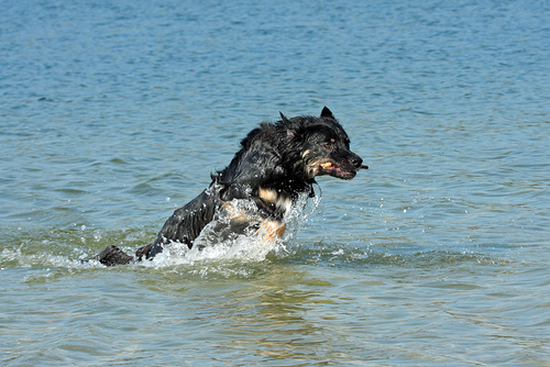

Score: 3.6933552264720353, Desc: dog be swim 
Score: 3.9866752352870485, Desc: brown dog swim 
Score: 4.162028326969154, Desc: dog carry stick 
Score: 4.424930884717329, Desc: black dog swim 
Score: 6.015913781975955, Desc: dog swim  
Score: 6.3708790355672935, Desc: dog swim  the


In [32]:
show_random_sample()

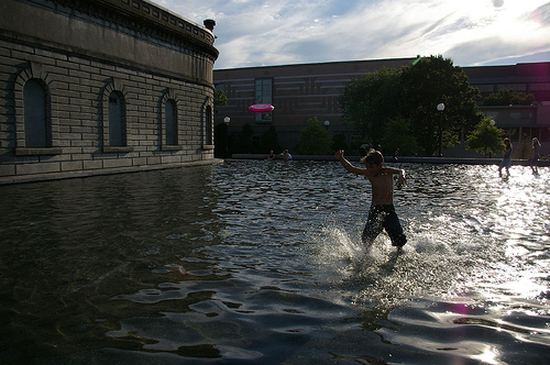

Score: 1.0130936682854796, Desc: child jump into pool 
Score: 1.863046137033909, Desc: girl jump into pool 
Score: 3.804337398215985, Desc: person jump into pool 
Score: 4.650245391038005, Desc: child play in pool 
Score: 4.802160324238259, Desc: girl play in pool 
Score: 6.88324970898668, Desc: man jump into pool 


In [33]:
show_random_sample()

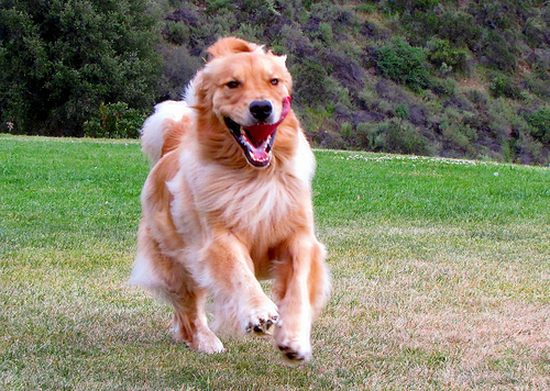

Score: 6.535999618568233, Desc: dog in field 
Score: 8.918699178190947, Desc: dog play outside 
Score: 9.171955315566061, Desc: golden retriever play 
Score: 10.70795712246517, Desc: dog play together 
Score: 11.739303169723536, Desc: dog in grass 
Score: 12.026051351008165, Desc: dog play  


In [34]:
show_random_sample()

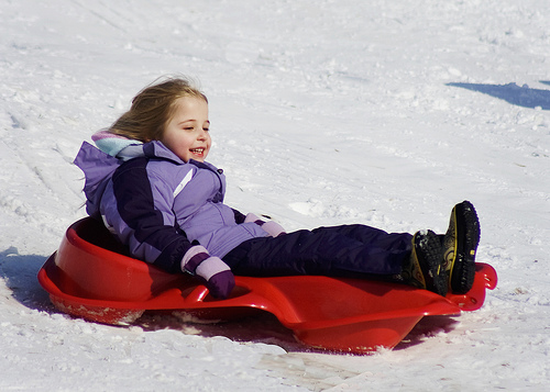

Score: 16.28124988196115, Desc: child on beach 
Score: 22.50864550229581, Desc: person on beach 
Score: 22.791953060948508, Desc: person on snowboard 
Score: 24.61981557075459, Desc: girl on beach 
Score: 30.72050618402245, Desc: person on wakeboard 
Score: 35.82081861841188, Desc: kid play outside 


In [35]:
show_random_sample()